# Dropout and Batch Normalization

In this notebook we will implement Dropout and Batch Normalization. Batch Normalization both improves generalization and training speed. Dropout is considered to be a regularization technique.

Goal of this lab is to:

* Implement and understand basic aspects of Dropout
* Implement and understand basic aspects of Batch Normalization

References:
* "Dropout: A Simple Way to Prevent Neural Networks from Overfitting": https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf

* "Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift": https://arxiv.org/abs/1502.03167

# Setup

In [1]:
%load_ext autoreload
%autoreload 
%matplotlib inline

import json
import matplotlib as mpl
from src import fmnist_utils
from src.fmnist_utils import *

import torch
from torch.autograd.function import InplaceFunction
from torch.autograd import Variable
from itertools import repeat
from torch import nn
from torch import optim

Using Theano backend.


In [2]:
def plot(H):
    plt.title(max(H['test_acc']))
    plt.plot(H['acc'], label="acc")
    plt.plot(H['test_acc'], label="test_acc")
    plt.legend()

mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['figure.figsize'] = (7, 7)
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['axes.labelsize'] = 12

(x_train, y_train), (x_test, y_test) = fmnist_utils.get_data(which="mnist")

# Whiteboard exercises

* (1.0) Write equations for training and inference phase of Dropout. Explain inference mode of Dropout (see https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf, p 1531)
* (0.5) Write equations for training and inference phase of Batch Normalization
* (0.5) Using either stability, or bias-variance perspective on generalization, argue why Dropout should prevent overfitting? 
* (1.0) Yet another perspective on generalization in Deep Networks is through the lenses of memorization, see https://arxiv.org/abs/1611.03530. Do you think Dropout prevents or encourages memorization? 

(And any left-out exercise from the previous lab)

# Dropout

Note: We use MNIST to be able to quickly and in a stable way fit data, which makes it a good target for studying generalization.

## Exercise 1: Implement and show better generalization of Dropout

Answer the following questions using the provided starting code and model:

a) What train and test accuracy did you achieve without dropout?

b) What train and test accuracy did you achieve with dropout (best alpha)?

Hint: use torch.randn()

In [14]:
class BernoulliDropout(nn.Module):
    def __init__(self, alpha=1.0):
        super(BernoulliDropout, self).__init__()
        self.alpha = torch.Tensor([alpha])
        
    def forward(self, x):
        """
        Sample noise e ~ B(alpha)
        Multiply noise h = h_ * e
        """
        if self.train():
            ??
        else:
            ??

In [12]:
answers = {"a": "", "b": ""}
json.dump(answers, open("8_ex1.json", "w"))

In [9]:
## Starting code

input_dim = 784
output_dim = 10
alpha = 0.00
hidden_dims =  [50, 50, 50]
model = torch.nn.Sequential()
previous_dim = input_dim
for id, D in enumerate(hidden_dims):
    model.add_module("dropout_{}".format(id), BernoulliDropout(alpha))
    model.add_module("linear_{}".format(id), torch.nn.Linear(previous_dim, D, bias=True))
    model.add_module("nonlinearity_{}".format(id), torch.nn.ReLU())
    previous_dim = D
model.add_module("final_layer", torch.nn.Linear(D, output_dim, bias=True))

loss = torch.nn.CrossEntropyLoss(size_average=True)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
H = train(loss=loss, model=model, x_train=x_train, y_train=y_train,
          x_test=x_test, y_test=y_test,
          optim=optimizer, batch_size=128, n_epochs=100)

plot(H)

# Batch Normalization

## Exercise 2: Implement Batch Normalization

Answer the following questions using the provided starting code and model:

a) What train and test accuracy did you achieve without BN?

b) What train and test accuracy did you achieve with BN?

c) Can you use a larger LR in network with BN?

In [70]:
def batch_norm(input, running_mean, running_var, weight, bias,
    training, momentum, eps):
    
    running_mean.set_(momentum * running_mean + (1 - momentum) * input.mean(0).data)
    running_var.set_(momentum * running_var + (1 - momentum) * input.std(0).data)
    
    if training:
        return ??
    else:
        return ??

class BatchNorm(nn.Module):

    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(BatchNorm, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.weight = nn.Parameter(torch.Tensor(num_features))
        self.bias = nn.Parameter(torch.Tensor(num_features))
        self.register_buffer('running_mean', torch.zeros(num_features))
        self.register_buffer('running_var', torch.ones(num_features))
        self.reset_parameters()

    def reset_parameters(self):
        self.running_mean.zero_()
        self.running_var.fill_(1)
        self.weight.data.uniform_()
        self.bias.data.zero_()

    def _check_input_dim(self, input):
        return NotImplemented

    def forward(self, input):
        return batch_norm(
            input, self.running_mean, self.running_var, self.weight, self.bias,
            self.training, self.momentum, self.eps)

    def extra_repr(self):
        return '{num_features}, eps={eps}, momentum={momentum}, affine={affine}, ' \
               'track_running_stats={track_running_stats}'.format(**self.__dict__)


100%|██████████| 100/100 [00:08<00:00, 11.75it/s]


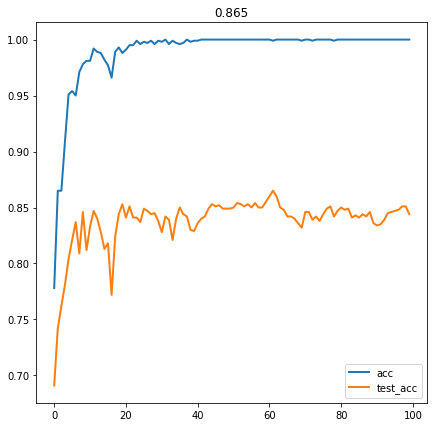

In [71]:
## Starting code

input_dim = 784
output_dim = 10
hidden_dims =  [50, 50, 50]
model = torch.nn.Sequential()
previous_dim = input_dim
for id, D in enumerate(hidden_dims):
    lin = torch.nn.Linear(previous_dim, D, bias=True)
    model.add_module("linear_{}".format(id), lin)
    bn = BatchNorm(D)
    model.add_module("bn_{}".format(id), bn)
    model.add_module("nonlinearity_{}".format(id), torch.nn.ReLU())
    previous_dim = D
model.add_module("final_layer", torch.nn.Linear(D, output_dim, bias=True))

loss = torch.nn.CrossEntropyLoss(size_average=True)
optimizer = optim.SGD(model.parameters(), lr=1.0, momentum=0.9)
H = train(loss=loss, model=model, x_train=x_train, y_train=y_train,
          x_test=x_test, y_test=y_test,
          optim=optimizer, batch_size=128, n_epochs=100)

plot(H)

In [16]:
answers = {"a": "", "b": "", "c": ""}
json.dump(answers, open("8_ex2.json", "w"))

## Exercise 3: Does it really reduce internal drift?

Produce an experiment similar to Figure 1 in https://arxiv.org/pdf/1502.03167.pdf (you can use our data and neural network). 

<img width=200 src="https://github.com/gmum/nn2018/raw/master/lab/fig/8/fig1.png">

Result is just a figure, save it to 8_3.png.

In [60]:
plt.savefig("8_ex3.png")